In [612]:
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pylab as plt
import json
import pandas as pd
import os
import seaborn as sns
import numpy as np

import itertools
import random
import copy
import time

# Analyzing Examples

# Example 1
Data are generated by running the WebPPL example in a browser and then downloading the resulting JSON.

In [67]:
ex1_sim_results = [
  {"Speaker": "Belief-Only\n($\lambda=0$)", "World": "Open", "Probability": 0.49999998763307907},
  {"Speaker": "Belief-Only\n($\lambda=0$)", "World": "Closed", "Probability": 0.4999999876330782},
  {"Speaker": "Belief-Only\n($\lambda=0$)", "World": "None", "Probability": 2.4733842721552372e-8},

  {"Speaker": "Combined\n($\lambda=.5$)", "World": "Open", "Probability":0.9182656837512339},
  {"Speaker": "Combined\n($\lambda=.5$)", "World": "Closed", "Probability": 0.08167109804637465},
  {"Speaker": "Combined\n($\lambda=.5$)", "World": "None", "Probability": 0.00006321820239158504}, 

]

ex1_df = pd.DataFrame(ex1_sim_results)
ex1_df

,Speaker,World,Probability
0,Belief-Only\n($\lambda=0$),Open,5.000000e-01
1,Belief-Only\n($\lambda=0$),Closed,5.000000e-01
2,Belief-Only\n($\lambda=0$),None,2.473384e-08
3,Combined\n($\lambda=.5$),Open,9.182657e-01
4,Combined\n($\lambda=.5$),Closed,8.167110e-02
5,Combined\n($\lambda=.5$),None,6.321820e-05


/Users/sumers/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


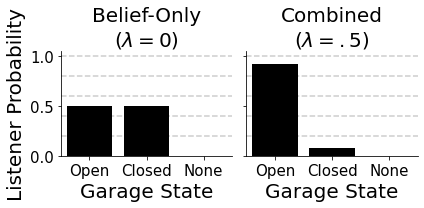

In [527]:
g = sns.FacetGrid(ex1_df, col="Speaker")
g.map(sns.barplot,'World','Probability', palette=['k'])

for i, ax in enumerate(g.axes.flat):
    for y in [.2, .4, .6, .8, 1]:
        ax.axhline(y, linestyle='--', c='k', zorder=0, alpha=.2)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Garage State', fontsize=20)
    if i == 0:
        ax.set_ylabel('Listener Probability', fontsize=20)
        ax.set_title('Belief-Only\n($\lambda=0$)', fontsize=20)
    else:
        ax.set_title('Combined\n($\lambda=.5$)', fontsize=20)

        plt.tight_layout()


In [529]:
ex1_path = 'javascript/analysis/ex1-out_of_gas.wppl'
script = '{} --require webppl-json'.format(ex1_path)

!webppl {script}

undefined


In [530]:
data = json.load(open('ex1-grid-results.json'))
ex1_sweep_df = load_results(data)
ex1_sweep_df.rename({'response_time':'garage'}, axis=1, inplace=True)

rename_dict = {'exists - open': 'Open', 'exists - closed': 'Closed', 'does not exist': 'None'}
ex1_sweep_df['garage'] = ex1_sweep_df.garage.apply(lambda x: rename_dict[x])

# No utterance costs
ex1_sweep_df = ex1_sweep_df[~ex1_sweep_df.includeUttCost]

# Round lambdas
ex1_sweep_df['lambda'] = ex1_sweep_df['lambda'].round(1)

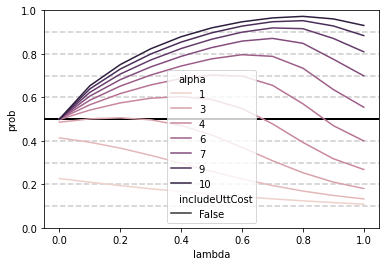

In [531]:
open_prob = ex1_sweep_df[ex1_sweep_df.garage == 'Open']
sns.lineplot(data=open_prob, x='lambda', y='prob', hue='alpha', style='includeUttCost')

plt.ylim(0, 1)
for y in range(1, 10, 1): 
    plt.axhline(y/10, c='k', alpha=.2, zorder=0, linestyle='--')
    plt.axhline(.5, c='k', zorder=0)

In [614]:
for_heatmap = ex1_sweep_df[ex1_sweep_df.garage == 'Open']

for_heatmap = for_heatmap[['alpha', 'lambda', 'prob']]

ex1_pivoted = for_heatmap.pivot(index='alpha', columns='lambda', values='prob')

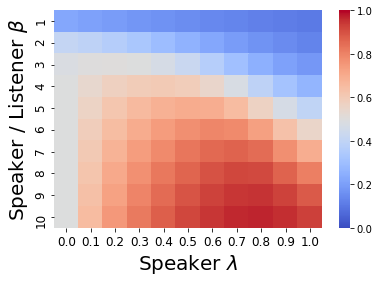

In [616]:
sns.heatmap(ex1_pivoted, cmap='coolwarm', vmin=0, vmax=1)
# sns.heatmap(pivoted, cmap='gray', vmin=.5, vmax=1)

# When alpha is too low, the speaker is unreliable and so prior probability that the garage is closed outweighs their utterance.
# When lambda = 0, there is no reason to believe the garage is open vs closed.
# Intermediate values of alpha and lambda generate the intuitive inference that the garage is likely open.
# High values of lambda make the speaker unreliable

plt.xlabel('Speaker $\lambda$', fontsize=20)
plt.ylabel('Speaker / Listener $\\beta$', fontsize=20)
plt.tick_params(labelsize=12)

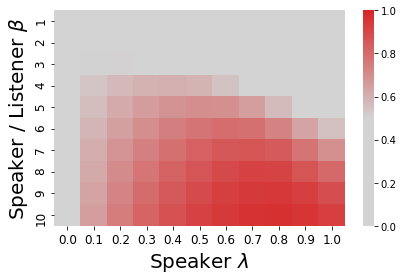

In [623]:
cmap = LinearSegmentedColormap.from_list('my_map', ['lightgray', 'lightgray', 'tab:red'])

sns.heatmap(ex1_pivoted, cmap=cmap, vmin=0, vmax=1)

plt.xlabel('Speaker $\lambda$', fontsize=20)
plt.ylabel('Speaker / Listener $\\beta$', fontsize=20)
plt.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('figures/appendix/appdx-simulations-grice-parameters.pdf')

/Users/sumers/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


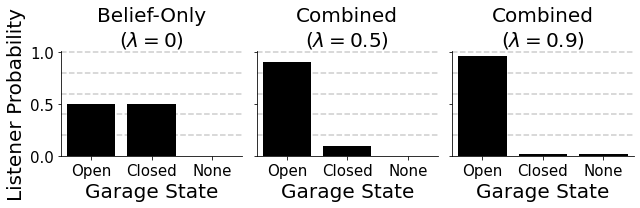

In [517]:
no_cost_alpha_10 = ex1_sweep_df[ex1_sweep_df.alpha == 10]

lambdas_to_plot = [0, .5, .9]
to_plot = no_cost_alpha_10[no_cost_alpha_10['lambda'].isin(lambdas_to_plot)]

g = sns.FacetGrid(to_plot, col="lambda")
g.map(sns.barplot,'garage','prob', palette=['k'])

for i, ax in enumerate(g.axes.flat):
    for y in [.2, .4, .6, .8, 1]:
        ax.axhline(y, linestyle='--', c='k', zorder=0, alpha=.2)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Garage State', fontsize=20)
    if i == 0:
        ax.set_ylabel('Listener Probability', fontsize=20)
        ax.set_title('Belief-Only\n($\lambda=0$)', fontsize=20)
    else:
        ax.set_title(f'Combined\n($\lambda={lambdas_to_plot[i]}$)', fontsize=20)

plt.tight_layout()

# Example 2
Data are generated by running the WebPPL example in a browser and then downloading the resulting JSON.

In [444]:
ex2_sim_results = [
  {"Speaker": "Belief-Only\n($\lambda=0$)", "World": "5:00", "Probability": 0.9999546021312976},
  {"Speaker": "Belief-Only\n($\lambda=0$)", "World": "5:05", "Probability": 0.000045397868702434354},
    {"Speaker": "Combined\n($\lambda=.9$)", "World": "5:00", "Probability": 0.7794655668133676},
  {"Speaker": "Combined\n($\lambda=.9$)", "World": "5:05", "Probability": 0.2205344331866323},
]

ex2_df = pd.DataFrame(ex2_sim_results)
ex2_df

,Speaker,World,Probability
0,Belief-Only\n($\lambda=0$),5:00,0.999955
1,Belief-Only\n($\lambda=0$),5:05,0.000045
2,Combined\n($\lambda=.9$),5:00,0.779466
3,Combined\n($\lambda=.9$),5:05,0.220534


/Users/sumers/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


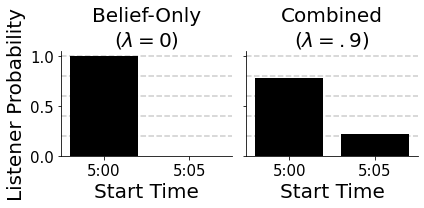

In [585]:
g = sns.FacetGrid(ex2_df, col="Speaker")
g.map(sns.barplot,'World','Probability', palette=['k'])

for i, ax in enumerate(g.axes.flat):
    for y in [.2, .4, .6, .8, 1]:
        ax.axhline(y, linestyle='--', c='k', zorder=0, alpha=.2)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Start Time', fontsize=20)
    if i == 0:
        ax.set_ylabel('Listener Probability', fontsize=20)
        ax.set_title('Belief-Only\n($\lambda=0$)', fontsize=20)
    else:
        ax.set_title('Combined\n($\lambda=.9$)', fontsize=20)

        plt.tight_layout()

In [605]:
ex2_path = 'javascript/analysis/ex2-lecture_start_time.wppl'
script = '{} --require webppl-json'.format(ex2_path)

!webppl {script}

undefined


In [606]:
data = json.load(open('ex2-grid-results.json'))
ex2_sweep_df = load_results(data)
ex2_sweep_df.rename({'response_time':'lecture_start'}, axis=1, inplace=True)

# No utterance costs
ex2_sweep_df = ex2_sweep_df[~ex2_sweep_df.includeUttCost]

# Round lambdas
ex2_sweep_df['lambda'] = ex2_sweep_df['lambda'].round(1)

late_prob = ex2_sweep_df[ex2_sweep_df.lecture_start == '5:05']

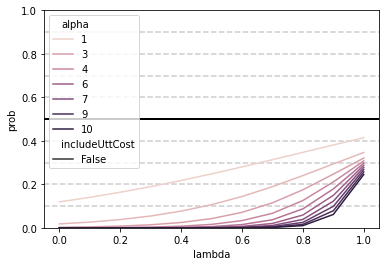

In [607]:
sns.lineplot(data=late_prob, x='lambda', y='prob', hue='alpha', style='includeUttCost')

plt.ylim(0, 1)
for y in range(1, 10, 1): 
    plt.axhline(y/10, c='k', alpha=.2, zorder=0, linestyle='--')
    plt.axhline(.5, c='k', zorder=0)

In [608]:
for_heatmap = late_prob[['alpha', 'lambda', 'prob']]
pivoted = for_heatmap.pivot(index='alpha', columns='lambda', values='prob')

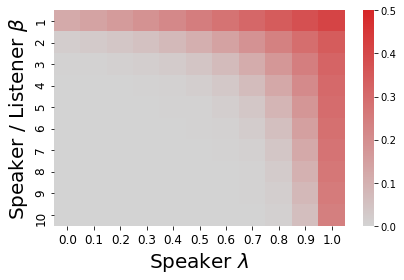

In [622]:
# sns.heatmap(pivoted, cmap='gray', vmin=0, vmax=.5)

cmap = LinearSegmentedColormap.from_list('my_map', ['lightgray', 'tab:red'])
# cmap = sns.light_palette("firebrick", as_cmap=True)
# cmap = "Reds"
sns.heatmap(pivoted, cmap=cmap, vmin=0, vmax=.5)

plt.xlabel('Speaker $\lambda$', fontsize=20)
plt.ylabel('Speaker / Listener $\\beta$', fontsize=20)
plt.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('figures/appendix/appdx-simulations-lecture-time-parameters.pdf')

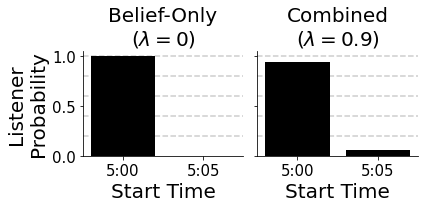

In [610]:
no_cost_alpha_10 = ex2_sweep_df[ex2_sweep_df.alpha == 10]

lambdas_to_plot = [0, .9]
to_plot = no_cost_alpha_10[no_cost_alpha_10['lambda'].isin(lambdas_to_plot)]

g = sns.FacetGrid(to_plot, col="lambda")
g.map(sns.barplot,'lecture_start','prob', palette=['k'], order=['5:00', '5:05'])

for i, ax in enumerate(g.axes.flat):
    for y in [.2, .4, .6, .8, 1]:
        ax.axhline(y, linestyle='--', c='k', zorder=0, alpha=.2)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Start Time', fontsize=20)
    if i == 0:
        ax.set_ylabel('Listener\nProbability', fontsize=20)
        ax.set_title('Belief-Only\n($\lambda=0$)', fontsize=20)
    else:
        ax.set_title(f'Combined\n($\lambda={lambdas_to_plot[i]}$)', fontsize=20)

plt.tight_layout()

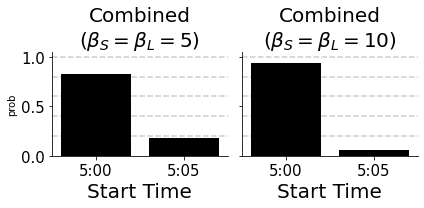

In [611]:
no_cost_alpha_10 = ex2_sweep_df[ex2_sweep_df['lambda'] == .9]

betas_to_plot = [5, 10]
to_plot = no_cost_alpha_10[no_cost_alpha_10['alpha'].isin(betas_to_plot)]

g = sns.FacetGrid(to_plot, col="alpha")
g.map(sns.barplot,'lecture_start','prob', palette=['k'], order=['5:00', '5:05'])

for i, ax in enumerate(g.axes.flat):
    for y in [.2, .4, .6, .8, 1]:
        ax.axhline(y, linestyle='--', c='k', zorder=0, alpha=.2)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('Start Time', fontsize=20)
    ax.set_title(f'Combined\n($\\beta_S=\\beta_L={betas_to_plot[i]}$)', fontsize=20)

plt.tight_layout()

(0.0, 1.1)

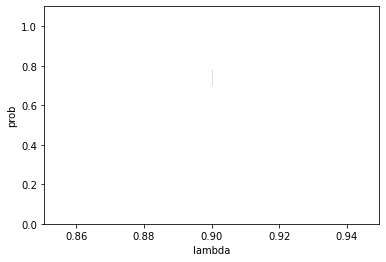

In [604]:
start_only = no_cost_alpha_10[no_cost_alpha_10['lecture_start'] == '5:00']

sns.lineplot(data=start_only, x='lambda', y='prob')
plt.ylim(0, 1.1)

# Example 3

Data are generated by running the WebPPL script locally via this notebook.

In [373]:
def load_results(raw_json):
    
    all_results = []
    for d in raw_json:
        res = copy.deepcopy(d['results'])
        for time, prob in zip(res['support'], res['probs']):
            res_copy = copy.deepcopy(d)
            del res_copy['results']
            res_copy.update({'response_time': time, 'prob': prob})
            all_results.append(res_copy)
    
    return pd.DataFrame(all_results)

In [518]:
ex3_path = 'javascript/analysis/ex3-telling_the_time.wppl'
script = '{} --require webppl-json'.format(ex3_path)

!webppl {script}

undefined


In [519]:
data = json.load(open('ex3-results-regular-new.json'))
df_regular = load_results(data)
df_regular['context'] = 'Control - Model'

data = json.load(open('ex3-results-watch-setting.json'))
df_watch = load_results(data)
df_watch['context'] = 'Watch - Model'

In [520]:
df_regular

,alpha,time,lambda,response_time,prob,context
0,10,4,1.0,0,2.033747e-09,Control - Model
1,10,4,1.0,1,1.370328e-11,Control - Model
2,10,4,1.0,2,1.370328e-11,Control - Model
3,10,4,1.0,3,6.648354e-03,Control - Model
4,10,4,1.0,4,6.648354e-03,Control - Model
...,...,...,...,...,...,...
6295,1,0,0.0,1,5.608143e-02,Control - Model
6296,1,0,0.0,2,5.608143e-02,Control - Model
6297,1,0,0.0,3,5.608143e-02,Control - Model
6298,1,0,0.0,4,5.608143e-02,Control - Model


In [521]:
df = pd.concat([df_regular, df_watch])
df['5x_resp'] = df.response_time % 5 == 0
df['lambda'] = df['lambda'].round(3)

In [522]:
multiples_by_params = df.groupby(['alpha', 'lambda', 'context', '5x_resp']).prob.sum() / 5

summary_df = multiples_by_params.reset_index()
summary_df = summary_df.rename({'prob':'pct_5x'}, axis=1)

In [523]:
mult_of_five = summary_df[summary_df['5x_resp']]
mult_of_five['pct_rounders'] = (mult_of_five['pct_5x'] - .2)/(.8)

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_13007/3371046775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_of_five['pct_rounders'] = (mult_of_five['pct_5x'] - .2)/(.8)


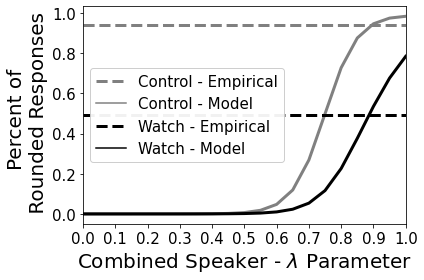

In [624]:
to_plot = mult_of_five[mult_of_five.alpha==10]
ax = sns.lineplot(data=to_plot, x='lambda', y='pct_rounders', hue='context', 
             palette=['gray', 'k'], linewidth=3)

ax.axhline(.94, c='gray', label='Control - Empirical', linewidth=3, linestyle='--')
ax.axhline(.49, c='k', label='Watch - Empirical', linewidth=3,  linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,1]

#add legend to plot
leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc=6, fontsize=15, framealpha=.95) 

# leg = plt.legend()

leg.get_lines()[0].set_linewidth(3)
leg.get_lines()[0].set_linestyle('--')
leg.get_lines()[2].set_linewidth(3)
leg.get_lines()[2].set_linestyle('--')

plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, step=0.1), fontsize=15);
plt.yticks(np.arange(0, 1.1, step=0.2), fontsize=15);

plt.gca().set_xlabel("Combined Speaker - $\lambda$ Parameter", size=20)
plt.gca().set_ylabel("Percent of \n Rounded Responses", size=20)


plt.tight_layout()
plt.savefig('figures/appendix/appdx-simulations-watch-time-rounding-parameters.pdf')

In [24]:
results = mult_of_five[mult_of_five['lambda'].isin([0, .9])]


results['Context'] = results.context.apply(lambda x: x.split(' ')[-1])
results['Speaker'] = results['lambda'].apply(lambda x: "Belief-Only\n($\lambda=0$)" if x == 0 else "Combined\n($\lambda=.9$)")

empirical_data = [{"Context": "Control", "Speaker": "Humans\n(empirical)", "pct_5x": .955, "pct_rounders": .94},
                  {"Context": "Watch", "Speaker": "Humans\n(empirical)", "pct_5x": .595, "pct_rounders": .49}]

full_results = pd.concat([results, pd.DataFrame(empirical_data)])

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_13007/1426694180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Context'] = results.context.apply(lambda x: x.split(' ')[-1])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_13007/1426694180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Speaker'] = results['lambda'].apply(lambda x: "Belief-Only\n($\lambda=0$)" if x == 0 else "Combined\n($\lambda=.9$)")


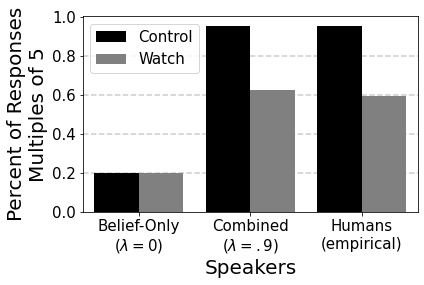

In [25]:
sns.barplot(data=full_results, x='Speaker', hue='Context', y='pct_5x', palette=['k', 'gray'])
plt.legend(fontsize=15)
plt.xlabel("Speakers", fontsize=20)
plt.ylabel("Percent of Responses\nMultiples of 5", fontsize=20)

plt.gca().tick_params(axis='both', labelsize=15)

for y in [.2, .4, .6, .8]:
    plt.axhline(y, c='k', alpha=.2, zorder=0, linestyle='--')

plt.tight_layout()
